### Data Cleaning Notebook: For a dataset with zipcode as rows, we did dummied the ratings and Price.
### For the categories I used countvectorizer to assign the matrix to the original data set.
### As the Countvecrizer does not perform well, I saved the data with two copies, one with countvecrizer one without

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.cluster import KMeans

import pickle

In [2]:
df= pd.read_csv('../data/data_income.csv')
df.head()

,Unnamed: 0,alias,category,city,id,latitude,longitude,price,rating,review_count,zip_code,ave_agi,count
0,0,重庆特色小面-chongqing-special-noodles-san-gabriel-3,"['noodles', 'chinese']",San Gabriel,mm6l24khOfXhKqn4pKVojA,34.103070,-118.091840,1,4.0,204.0,91776,37.21102,198
1,1,yung-ho-cafe-san-gabriel-2,"['taiwanese', 'chinese', 'breakfast_brunch']",San Gabriel,zO8V4fi49QQMn4Sa_0OS9g,34.081429,-118.084785,1,3.0,263.0,91776,37.21102,198
2,2,yun-nan-168-san-gabriel,['chinese'],San Gabriel,6J_4QelYHplaLHzof1VEyg,34.080849,-118.090324,1,3.0,4.0,91776,37.21102,198
3,3,yum-cha-cafe-san-gabriel,"['dimsum', 'hotdogs']",San Gabriel,KD_fdBnwN3TbJYJ8mcvq4Q,34.078899,-118.092026,1,3.0,138.0,91776,37.21102,198
4,4,yuk-dae-jang-san-gabriel-2,['korean'],San Gabriel,DwvljRkxkMEljQBYX-MeTw,34.102080,-118.109870,2,4.5,158.0,91776,37.21102,198


In [3]:
df.shape

(28209, 13)

In [4]:
df.drop(columns = ['id','Unnamed: 0'], inplace = True)

## change the data set from restaurant based to zipcode based

In [5]:
df_pivot = df.pivot_table(index = ['zip_code'])
df_pivot.head()

,ave_agi,count,latitude,longitude,price,rating,review_count
zip_code,,,,,,,
90001,25.152933,93,33.976603,-118.248763,1.279570,3.623656,49.483871
90002,24.410496,21,33.954426,-118.245431,1.095238,3.380952,27.904762
90003,23.404622,71,33.972703,-118.271297,1.197183,3.281690,35.929577
90004,59.128947,155,34.075176,-118.305680,1.529032,3.835484,240.987097
90005,45.821128,147,34.059249,-118.300776,1.639456,3.717687,358.482993


##  Create New column for the combo of Price*review_count

In [6]:
df_pivot['price*review_count']=df_pivot['price']*df_pivot['review_count']

In [7]:
df_pivot.head()

,ave_agi,count,latitude,longitude,price,rating,review_count,price*review_count
zip_code,,,,,,,,
90001,25.152933,93,33.976603,-118.248763,1.279570,3.623656,49.483871,63.318071
90002,24.410496,21,33.954426,-118.245431,1.095238,3.380952,27.904762,30.562358
90003,23.404622,71,33.972703,-118.271297,1.197183,3.281690,35.929577,43.014283
90004,59.128947,155,34.075176,-118.305680,1.529032,3.835484,240.987097,368.477045
90005,45.821128,147,34.059249,-118.300776,1.639456,3.717687,358.482993,587.717016


## Breakdown the price from original Pivot table(average) to count how many we have for each price category

In [8]:
count_price = (pd.crosstab(df["zip_code"], df['price']))
count_price.columns = ['price_1','price_2','price_3','price_4']
count_price.head()

,price_1,price_2,price_3,price_4
zip_code,,,,
90001,67,26,0,0
90002,19,2,0,0
90003,60,9,1,1
90004,77,74,4,0
90005,56,88,3,0


# Break Down for Rating column

In [9]:
count_rating = (pd.crosstab(df["zip_code"], df['rating']))
count_rating.columns = ['rating_0.0','rating_1.0','rating_1.5','rating_2.0','rating_2.5','rating_3.0','rating_3.5','rating_4.0','rating_4.5','rating_5']
count_rating.head()

,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
zip_code,,,,,,,,,,
90001,0,0,4,8,9,9,14,20,17,12
90002,0,0,3,4,1,0,1,6,3,3
90003,0,2,7,10,7,7,8,11,10,9
90004,0,0,1,2,12,15,27,57,27,14
90005,0,1,2,5,5,19,26,58,30,1


## combine price and rating to zipcode file

In [10]:
df_count = pd.merge(count_price, count_rating, left_on = 'zip_code', right_on = 'zip_code')
df_count.head()

,price_1,price_2,price_3,price_4,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
zip_code,,,,,,,,,,,,,,
90001,67,26,0,0,0,0,4,8,9,9,14,20,17,12
90002,19,2,0,0,0,0,3,4,1,0,1,6,3,3
90003,60,9,1,1,0,2,7,10,7,7,8,11,10,9
90004,77,74,4,0,0,0,1,2,12,15,27,57,27,14
90005,56,88,3,0,0,1,2,5,5,19,26,58,30,1


In [11]:
df_count.shape

(344, 14)

In [12]:
df_pivot.shape

(344, 8)

## Below is the combined data for zipcode, price, and rating, without countvecrizer the catogory

In [13]:
df_dummy = pd.merge(df_pivot, df_count, on="zip_code")
df_dummy.drop(columns = ['price','rating'] ,inplace = True)
df_dummy.reset_index(inplace = True)
df_dummy.head()

,zip_code,ave_agi,count,latitude,longitude,review_count,price*review_count,price_1,price_2,price_3,...,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
0,90001,25.152933,93,33.976603,-118.248763,49.483871,63.318071,67,26,0,...,0,0,4,8,9,9,14,20,17,12
1,90002,24.410496,21,33.954426,-118.245431,27.904762,30.562358,19,2,0,...,0,0,3,4,1,0,1,6,3,3
2,90003,23.404622,71,33.972703,-118.271297,35.929577,43.014283,60,9,1,...,0,2,7,10,7,7,8,11,10,9
3,90004,59.128947,155,34.075176,-118.305680,240.987097,368.477045,77,74,4,...,0,0,1,2,12,15,27,57,27,14
4,90005,45.821128,147,34.059249,-118.300776,358.482993,587.717016,56,88,3,...,0,1,2,5,5,19,26,58,30,1


In [14]:
df_dummy['zip_code'] = df_dummy['zip_code'].astype(str)

In [15]:
df_dummy.dtypes

zip_code               object
ave_agi               float64
count                   int64
latitude              float64
longitude             float64
review_count          float64
price*review_count    float64
price_1                 int64
price_2                 int64
price_3                 int64
price_4                 int64
rating_0.0              int64
rating_1.0              int64
rating_1.5              int64
rating_2.0              int64
rating_2.5              int64
rating_3.0              int64
rating_3.5              int64
rating_4.0              int64
rating_4.5              int64
rating_5                int64
dtype: object

In [16]:
#df_dummy = df_dummy[df_dummy['count']>=50]

In [17]:
#df_dummy.to_csv('../data/data_nocv.csv')

# Making the category a matrix via countvectrizor 

In [18]:
cate_dict = df['category'].to_dict()

In [19]:
for i in cate_dict:
    cate_dict[i] = cate_dict[i].replace('[', '')
    cate_dict[i] = cate_dict[i].replace(']', '')
    cate_dict[i] = cate_dict[i].replace('\'', '')
    cate_dict[i] = cate_dict[i].split(', ')

In [20]:
df_cate= pd.DataFrame.from_dict(cate_dict, orient = 'index')
df_cate.head()

,0,1,2,3,4
0,noodles,chinese,None,None,None
1,taiwanese,chinese,breakfast_brunch,None,None
2,chinese,None,None,None,None
3,dimsum,hotdogs,None,None,None
4,korean,None,None,None,None


In [21]:
df_cate['zip_code'] = df['zip_code']
df_cate

,0,1,2,3,4,zip_code
0,noodles,chinese,None,None,None,91776
1,taiwanese,chinese,breakfast_brunch,None,None,91776
2,chinese,None,None,None,None,91776
3,dimsum,hotdogs,None,None,None,91776
4,korean,None,None,None,None,91776
...,...,...,...,...,...,...
28204,foodtrucks,burgers,sandwiches,None,None,92807
28205,burgers,hotdogs,None,None,None,93955
28206,foodstands,None,None,None,None,92056
28207,cheesesteaks,sandwiches,chicken_wings,None,None,92845


In [22]:
categories_df = df_cate.astype(str).groupby('zip_code').agg(lambda x: ' '.join(x.unique())) ##borrowwed from Erin Hwang 

In [23]:
categories_df['cate_text_by_zip'] = categories_df[0] + ' ' + categories_df[1] + ' ' + categories_df[2] + ' ' + categories_df[3] + ' ' + categories_df[4]
categories_df.head()##borrowwed from Erin Hwang

,0,1,2,3,4,cate_text_by_zip
zip_code,,,,,,
90001,foodtrucks chicken_wings donuts hotdogs street...,comfortfood None coffee asianfusion japanese v...,sandwiches None hotdog food catering mexican m...,None,None,foodtrucks chicken_wings donuts hotdogs street...
90002,coffee hotdogs mexican tacos sandwiches salvad...,breakfast_brunch burgers None foodstands hotdo...,None coffee mexican chicken_wings breakfast_br...,None,None,coffee hotdogs mexican tacos sandwiches salvad...
90003,sportsbars japanese donuts soulfood burgers ta...,None sandwiches coffee mexican hotdogs foodsta...,None coffee sandwiches meats customcakes chick...,None,None,sportsbars japanese donuts soulfood burgers ta...
90004,korean japanese desserts bbq streetvendors piz...,chinese None coffee noodles korean seafood mex...,noodles None korean smokehouse raw_food italia...,None,None,korean japanese desserts bbq streetvendors piz...
90005,korean donuts coffee hotdogs chinese thai chic...,None noodles coffee bubbletea asianfusion chic...,None sandwiches juicebars italian korean sushi...,None,None,korean donuts coffee hotdogs chinese thai chic...


In [24]:
cvec = CountVectorizer()

In [25]:
categories_df.reset_index(inplace = True)

In [26]:
X = categories_df['cate_text_by_zip']
y = categories_df['zip_code']

In [27]:
df_cate = pd.DataFrame(cvec.fit_transform(X).toarray(),
                columns=cvec.get_feature_names() ) #
df_cate.head()

,acaibowls,accessories,acupuncture,afghani,african,airportlounges,amusementparks,antiques,appliances,arabian,...,whiskeybars,wholesale_stores,wholesalers,wine_bars,wineries,winetasteclasses,winetastingroom,womenscloth,wraps,yoga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## save the data with countvecrizer

In [28]:
df = pd.concat([df_dummy, df_cate], axis=1, sort=False)
df.head()

,zip_code,ave_agi,count,latitude,longitude,review_count,price*review_count,price_1,price_2,price_3,...,whiskeybars,wholesale_stores,wholesalers,wine_bars,wineries,winetasteclasses,winetastingroom,womenscloth,wraps,yoga
0,90001,25.152933,93,33.976603,-118.248763,49.483871,63.318071,67,26,0,...,0,0,0,0,0,0,0,0,0,0
1,90002,24.410496,21,33.954426,-118.245431,27.904762,30.562358,19,2,0,...,0,0,0,0,0,0,0,0,0,0
2,90003,23.404622,71,33.972703,-118.271297,35.929577,43.014283,60,9,1,...,0,0,0,0,0,0,0,0,0,0
3,90004,59.128947,155,34.075176,-118.305680,240.987097,368.477045,77,74,4,...,0,0,0,0,0,0,0,0,0,0
4,90005,45.821128,147,34.059249,-118.300776,358.482993,587.717016,56,88,3,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df.to_csv('../data/data_cv.csv')

In [30]:
#count_price_rating = (pd.crosstab(df["zip_code"], df['price*rating']))
#count_price_rating.head()

In [31]:
#numeric_data = df._get_numeric_data().columns

## Begin to Model

## Tried both data with vecorizer and without, turns out the data without vectorizer performs better, so I will stick with this one

## Jerry's way to countvectorizer

In [32]:
#df_dummy = pd.read_csv('../data/data_income.csv')

In [33]:
# X = df_dummy.drop(columns=['ave_agi','latitude','longitude'])
# #features = list(X.columns)
# y = df_dummy['ave_agi']

In [34]:

# # https://stackoverflow.com/questions/46778392/
# # https://stackoverflow.com/questions/34734940/

# '''
# use function for both X_train and X_test
# you can save as a different DF or overwrite

# maybe this can go in a markdown cell:

#     We first use CountVectorizer() to create dummy columns for
#     each category. We multiply these columns the price by the 
#     dummy categories so that we can get a price inside the
#     category column.
    
#     e.g. if a Korean restaurant has a price of '3', then we 
#     want that row to have a '3' in the 'korean' column.
    
#     This allows us to standard scale each category column so
#     that we can assess the relative price of each business
#     listing given its category. That way, if one area has
#     relatively expensive Korean restaurants, and another area
#     has relatively inexpensive jewelry stores, those scaled
#     factors may have an effect in our ability to model.
    
# '''

# def category_pricer(X, y, state=42):
#     '''
#     Adds scaled price columns to a Yelp Business DataFrame.
    
#     Arguments:
#         X:              dataframe containing all features
#         y:              array containing all targets
#         state:          random state of train_test_split()
                                    
#     Returns:
#         X_train, X_test, y_train, y_test
#         X_train and X_test contain two new columns:
#         'price_sc':     scaled price
#         'adj_price':    mean of category-scaled prices

#     Goal:   to standard scale the price of a business listing
#             given its category.
#     '''
#     X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     random_state=state)    
    
#     # instantiate CountVectorizer() and fit 'category'
#     cvect = CountVectorizer()

#     # fit_transform train data
#     c_train = cvect.fit_transform(X_train['category']).toarray()
#     for i in range(len(c_train)):
#         c_train[i] = c_train[i] * X_train['price'].values[i]
#     cat_train = cvect.get_feature_names()
#     C_train = pd.DataFrame(c_train, columns=cat_train)
#     C_train.replace(0, np.NaN, inplace=True)
    
#     # only transform test data
#     c_test = cvect.transform(X_test['category']).toarray()
#     for j in range(len(c_test)):
#         c_test[j] = c_test[j] * X_test['price'].values[j]
#     cat_test = cvect.get_feature_names()
#     C_test = pd.DataFrame(c_test, columns=cat_test)
#     C_test.replace(0, np.NaN, inplace=True)
    
#     # standard scale each category
#     sc = StandardScaler()
#     S_train = pd.DataFrame(sc.fit_transform(C_train), columns=cat_train)
#     S_test = pd.DataFrame(sc.transform(C_test), columns=cat_test)
    
#     X_train['price_sc'] = sc.fit_transform(X_train[['price']])
#     X_test['price_sc'] = sc.transform(X_test[['price']])
    
#     # right now if a listing belongs to multiple categories,
#     # it will take the average of the scaled category scores.
#     X_train['adj_price'] = list(S_train.mean(axis=1))
#     X_test['adj_price'] = list(S_test.mean(axis=1))
    
#     return X_train, X_test, y_train, y_test

In [35]:
#df_dummy

In [36]:
#category_pricer(X,y,state=42)

In [37]:
# numeric_data = df_dummy._get_numeric_data().columns
# X = df_dummy._get_numeric_data().drop(columns=['ave_agi','latitude','longitude'])
# features = list(X.columns)
# y = df_dummy['ave_agi']
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# X_poly = poly.fit_transform(X)
# X_poly_train,X_poly_test,y_train,y_test = train_test_split(X_poly,y, random_state = 42)
# ss=StandardScaler()
# ss.fit(X_poly_train)
# X_train_sc=ss.transform(X_poly_train)
# X_test_sc = ss.transform(X_poly_test)
# lm = LinearRegression()
# lm.fit(X_train_sc, y_train)
# l_alpha = np.logspace(-1, 2, 100)
# lasso = LassoCV(alphas=l_alpha, cv=5, max_iter=1000)
# lasso.fit(X_train_sc, y_train)


In [38]:
#lm.score(X_test_sc,y_test)

In [39]:
#lasso.alpha_

In [40]:
#lasso.score(X_test_sc, y_test)

In [41]:
# coef_df = pd.DataFrame({"Predictor Variables":poly.get_feature_names(features),"Coef_weight":lasso.coef_,'absolute':abs(lasso.coef_)})
# coef_df.sort_values(by='absolute',ascending = False).head(20)

In [42]:
#df_dummy['price*rating*price_3']=df_dummy['price*rating']*df_dummy['price_3']

In [43]:
#df_dummy['price*review_count^2']=df_dummy['price*review_count']**2

In [44]:
X = df_dummy.drop(columns=['ave_agi','latitude','longitude','zip_code'])
#features = list(X.columns)
y = df_dummy['ave_agi']

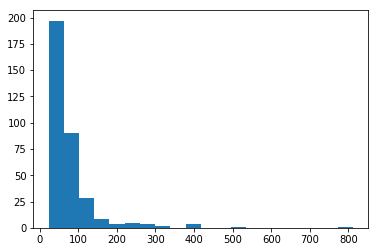

In [45]:
plt.hist(df["ave_agi"], bins=20);

In [46]:
y = np.log(df_dummy["ave_agi"])  #y = np.log(df.copy()["ave_agi"])

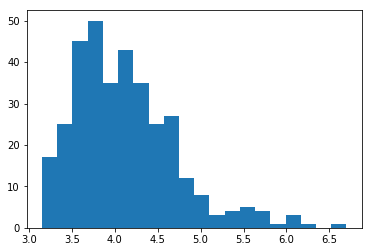

In [47]:
plt.hist(y, bins=20);

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.3
)

In [49]:
# sc = StandardScaler()  did not have significant impact
# X_train = sc.fit_transform(X_train)
# X_test =sc.transform(X_test)

# Trying different models
 - linear regression
 - knn regression
 - decision tree
 - bagging
 - random_forest
 - ada boost
 - support_vector

In [50]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

cart_reg = DecisionTreeRegressor()
cart_reg.fit(X_train, y_train)

bagged_reg = BaggingRegressor()
bagged_reg.fit(X_train, y_train)

random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)

adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train, y_train)

support_vector_reg = SVR()
support_vector_reg.fit(X_train, y_train)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

# Evaluate our models

In [51]:
X_train

,count,review_count,price*review_count,price_1,price_2,price_3,price_4,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
31,129,323.201550,450.978908,83,43,1,2,0,0,1,5,8,13,35,35,27,5
245,72,237.375000,349.468750,39,32,1,0,0,0,0,2,7,4,17,24,14,4
277,169,419.538462,583.381884,104,64,1,0,0,1,0,6,13,18,51,65,14,1
165,69,298.478261,449.880277,35,33,1,0,0,0,2,0,3,11,19,24,9,1
250,99,206.484848,291.998776,58,41,0,0,0,0,2,8,6,9,20,31,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,64,141.671875,188.157959,44,19,1,0,0,0,0,7,5,6,9,18,14,5
71,78,213.358974,292.684747,49,29,0,0,0,0,1,6,8,12,23,16,11,1
106,147,253.462585,372.434819,86,53,8,0,0,0,2,6,3,20,31,58,22,5
270,81,257.086420,361.825332,50,29,2,0,0,0,0,5,6,10,34,18,6,2


In [52]:
def rmse_score(model, X_train, X_test, y_train, y_test):
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(X_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(X_test))
    rmse_train = mse_train ** 0.5
    rmse_test = mse_test ** 0.5
    
    print("The training RMSE for " + str(model) + " is: " + str(rmse_train))
    print("The testing RMSE for " + str(model) + " is: " + str(rmse_test))
    return (rmse_train, rmse_test)

## Evaluate linear regression

In [53]:
rmse_score(linear_reg, X_train, X_test, y_train, y_test)

The training RMSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) is: 0.4188864354669736
The testing RMSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) is: 0.45843429319409684


(0.4188864354669736, 0.45843429319409684)

In [54]:
print(linear_reg.score(X_train, y_train))
print (linear_reg.score(X_test, y_test))

0.503414338638636
0.44089391031310526


In [55]:
linear_reg.coef_

array([-1.48252029e-03, -2.33879145e-03,  2.09456388e-03, -1.12498765e-02,
       -2.45499092e-03, -5.48069838e-03,  1.77030455e-02,  1.56125113e-17,
        1.30985424e-02, -6.21131982e-02, -1.22264321e-02,  1.92178452e-02,
        2.42980843e-02,  1.16570708e-02,  1.33408797e-03,  4.91484945e-03,
       -1.66337007e-03])

## Evaluate Knn

In [56]:
rmse_score(knn_reg, X_train, X_test, y_train, y_test)

The training RMSE for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform') is: 0.3751693957601213
The testing RMSE for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform') is: 0.4864711252338396


(0.3751693957601213, 0.4864711252338396)

In [57]:
print(knn_reg.score(X_train, y_train))
print (knn_reg.score(X_test, y_test))

0.6016577346909096
0.37041530413070256


## Evaluate decision tree

In [58]:
rmse_score(cart_reg, X_train, X_test, y_train, y_test)

The training RMSE for DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') is: 2.6862296009259277e-05
The testing RMSE for DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') is: 0.5688272450667586


(2.6862296009259277e-05, 0.5688272450667586)

In [59]:
print(cart_reg.score(X_train, y_train))
print (cart_reg.score(X_test, y_test))

0.999999997957849
0.13920287753658078


## Evaluate Bagging model

In [60]:
rmse_score(bagged_reg, X_train, X_test, y_train, y_test)

The training RMSE for BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False) is: 0.1868770644810752
The testing RMSE for BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False) is: 0.43547051092116323


(0.1868770644810752, 0.43547051092116323)

In [61]:
print(bagged_reg.score(X_train, y_train))
print (bagged_reg.score(X_test, y_test))

0.9011643578938552
0.4955042300404047


## Evaluate random forest

In [62]:
rmse_score(random_forest_reg, X_train, X_test, y_train, y_test)

The training RMSE for RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) is: 0.18655251169934117
The testing RMSE for RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) is: 0.4

(0.18655251169934117, 0.47875202452667587)

In [63]:
print(random_forest_reg.score(X_train, y_train))
print (random_forest_reg.score(X_test, y_test))

0.9015073590853974
0.39023671042882335


## Evaluate adaboost

In [64]:
rmse_score(adaboost_reg, X_train, X_test, y_train, y_test)

The training RMSE for AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None) is: 0.3032030083270788
The testing RMSE for AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None) is: 0.42862787581460415


(0.3032030083270788, 0.42862787581460415)

In [65]:
print(adaboost_reg.score(X_train, y_train))
print (adaboost_reg.score(X_test, y_test))

0.7398231848637896
0.5112341532652634


## Evaluate Support vector regression

In [66]:
rmse_score(support_vector_reg, X_train, X_test, y_train, y_test)

The training RMSE for SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) is: 0.16720546478210074
The testing RMSE for SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) is: 0.6168292898301106


(0.16720546478210074, 0.6168292898301106)

In [67]:
print(support_vector_reg.score(X_train, y_train))
print (support_vector_reg.score(X_test, y_test))

0.9208770418110276
-0.012208553552083501


## Test Model with pipelines

In [68]:
pipe = Pipeline([
    ('linear', LinearRegression())
])

pipe_params = {
                 'linear__fit_intercept': [True,False], 
                 'linear__normalize': [True, False],
                 'linear__copy_X': [True, False],
                 'linear__n_jobs': [1,5,10]
}

pipe_gridsearch = GridSearchCV(pipe, 
                                 pipe_params, 
                                 cv=5, 
                                 verbose=1)
pipe_gridsearch.fit(X_train, y_train);
print(pipe_gridsearch.best_score_)
pipe_gridsearch.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.4196955815436761


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished


Pipeline(memory=None,
         steps=[('linear',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1,
                                  normalize=False))],
         verbose=False)

In [69]:
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}
knn_gridsearch = GridSearchCV(KNeighborsRegressor(), 
                              knn_params, 
                              cv=5, 
                              verbose=1)
knn_gridsearch.fit(X_train, y_train);
best_knn = knn_gridsearch.best_estimator_
best_knn.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


0.3850972942225037

In [70]:
cart_params = {
    'max_depth': [15,25,50]
    
}
cart_gridsearch = GridSearchCV(DecisionTreeRegressor(), 
                              cart_params, 
                              cv=5, 
                              verbose=1)
cart_gridsearch.fit(X_train, y_train);
best_cart = cart_gridsearch.best_estimator_
best_cart.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


0.0008454706249206856

In [71]:
BaggingRegressor()

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [72]:
bag_params = {
    'n_estimators': [120,140,160],
    
    
}
bag_gridsearch = GridSearchCV(BaggingRegressor(),
                              bag_params,
                              cv=5, 
                              verbose=1)
bag_gridsearch.fit(X_train, y_train);
best_bag = bag_gridsearch.best_estimator_
print (best_bag)
best_bag.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.4s finished


BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=120,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)


0.5398977642431843

In [73]:
rf_params = {
    'n_estimators': [100,110,120],
    'max_depth':[6,7,8,9]
    
    
}
rf_gridsearch = GridSearchCV(RandomForestRegressor(), 
                              rf_params,
                              cv=5, 
                              verbose=1)
rf_gridsearch.fit(X_train, y_train);
best_rf = rf_gridsearch.best_estimator_
print (best_rf)
best_rf.score(X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   12.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


0.5201272978688327

In [74]:
AdaBoostRegressor()

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [75]:
ada_params = {
    'n_estimators': [75,85,90]
}
ada_gridsearch = GridSearchCV(AdaBoostRegressor(), 
                              ada_params, 
                              cv=5, 
                              verbose=1)
ada_gridsearch.fit(X_train, y_train);
best_ada = ada_gridsearch.best_estimator_
print (best_ada)
best_ada.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=75, random_state=None)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.4s finished


0.5185570625378194

In [76]:
svr_params = {
    'degree': [2,3]
}
svr_gridsearch = GridSearchCV(SVR(), 
                              svr_params, 
                              cv=5, 
                              verbose=1)
svr_gridsearch.fit(X_train, y_train);
best_svr = svr_gridsearch.best_estimator_
print (best_svr)
best_svr.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

Fitting 5 folds for each of 2 candidates, totalling 10 fits
SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", 

-0.012208553552083501

|model|RMSE Train|RMSE Test|R2 Train|R2 Test|pipeline R2 test|
| --- | --- | --- | --- | ---|---|
|Linear Regression| 0.414|0.44|0.54|0.56|0.43|
|KNN Regression| 0.39|0.51|0.56|0.31|0.33|
|Decision Tree Regression| 8.11e05|0.56|0.99|0.16|0.03|
|Baggin Regression| 0.19|0.46|0.89|0.45|0.54|
|Random Forest Regression| 0.17|0.42|0.92|0.53|0.536|
|Adaboost Regression| 0.29|0.42|0.77|0.53|0.543|
|support vector Regression| 0.17|0.62|0.92|-0.02|-0.02|

# Using KMean Cluster to group Zipcodes

In [77]:
X.head()

,count,review_count,price*review_count,price_1,price_2,price_3,price_4,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
0,93,49.483871,63.318071,67,26,0,0,0,0,4,8,9,9,14,20,17,12
1,21,27.904762,30.562358,19,2,0,0,0,0,3,4,1,0,1,6,3,3
2,71,35.929577,43.014283,60,9,1,1,0,2,7,10,7,7,8,11,10,9
3,155,240.987097,368.477045,77,74,4,0,0,0,1,2,12,15,27,57,27,14
4,147,358.482993,587.717016,56,88,3,0,0,1,2,5,5,19,26,58,30,1


In [78]:
def transfer_tune(X, y, k):
    location_data = df_dummy[["latitude", "longitude"]]
    km = KMeans(n_clusters=k,random_state = 42 )
    km.fit(location_data)
    X.loc[:, "cluster"] = km.predict(location_data)
    X_dummy = pd.get_dummies(columns=["cluster"], data=X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
    )
    best_bag.fit(X_train, y_train)
    r2 =best_bag.score(X_test, y_test)
    print(f"{k} : {r2}")

In [79]:
for k in range(20, 50, 1):
    transfer_tune(X, y, k)

20 : 0.555019964838849
21 : 0.5501157449841336
22 : 0.5508627020016604
23 : 0.545618220494727
24 : 0.54132290812849
25 : 0.5225763038820217
26 : 0.5420354965087638
27 : 0.5315003656564319
28 : 0.5938413220469662
29 : 0.5247668800400751
30 : 0.5458080119763498
31 : 0.5224431565943537
32 : 0.5519370111781081
33 : 0.5102749060119416
34 : 0.5282905928621872
35 : 0.5449463019155629
36 : 0.5346242767708052
37 : 0.6029014952040331
38 : 0.5277349498232351
39 : 0.598337006695702
40 : 0.6043610146396673
41 : 0.5964633893737243
42 : 0.5908329401915844
43 : 0.5576367475025719
44 : 0.5986100912977693
45 : 0.5554294208405242
46 : 0.6034534393194102
47 : 0.6021142107368075
48 : 0.563154476567981
49 : 0.5782249009576768


In [80]:
location_data = df_dummy[["latitude", "longitude"]]
km = KMeans(n_clusters=46, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

best_bag.fit(X_train, y_train)
r2 = best_bag.score(X_test, y_test)
print (r2)

0.598893029823121


In [81]:
X_train.columns

Index(['count', 'review_count', 'price*review_count', 'price_1', 'price_2',
       'price_3', 'price_4', 'rating_0.0', 'rating_1.0', 'rating_1.5',
       'rating_2.0', 'rating_2.5', 'rating_3.0', 'rating_3.5', 'rating_4.0',
       'rating_4.5', 'rating_5', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7',
       'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12',
       'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17',
       'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22',
       'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27',
       'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31', 'cluster_32',
       'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36', 'cluster_37',
       'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41', 'cluster_42',
       'cluster_43', 'cluster_44', 'cluster_45'],
      dtype='object')

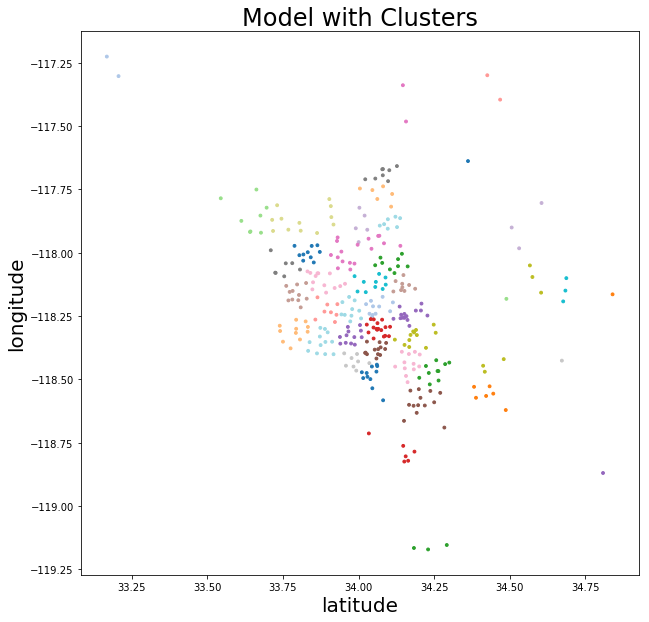

In [82]:
plt.figure(figsize=(10, 10))
plt.scatter(df_dummy.latitude, df_dummy.longitude, c=km.labels_, s=8, cmap="tab20")
plt.xlabel("latitude", fontsize = 20)
plt.ylabel("longitude", fontsize = 20)
plt.title('Model with Clusters', fontsize = 24);

In [83]:
X_cluster = pd.concat([X_train,X_test],axis = 0, sort = False)

In [84]:
X_cluster.sort_index().tail(10)

,count,review_count,price*review_count,price_1,price_2,price_3,price_4,rating_0.0,rating_1.0,rating_1.5,...,cluster_36,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45
334,113,143.681416,221.243950,54,58,0,1,0,0,6,...,1,0,0,0,0,0,0,0,0,0
335,32,73.531250,82.722656,28,4,0,0,0,0,2,...,1,0,0,0,0,0,0,0,0,0
336,2,41.500000,41.500000,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,2,43.000000,64.500000,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,7,31.142857,31.142857,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
339,1,23.000000,23.000000,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
340,1,36.000000,36.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
341,1,20.000000,40.000000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342,1,39.000000,39.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343,1,3.000000,6.000000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
X_cluster = pd.concat([df_dummy['zip_code'],X_cluster.sort_index()],axis = 1)

In [86]:
X_cluster.to_csv('../data/X_cluster.csv')

In [87]:
y_pred = best_bag.predict(X_test)

In [88]:
#X_test['residual']=y_pred

In [89]:
#X_test[X_test['residual']>30]

In [90]:
df_dummy['pred']=best_bag.predict(X_cluster)

In [91]:
df_dummy[df_dummy['zip_code']=='90004']

,zip_code,ave_agi,count,latitude,longitude,review_count,price*review_count,price_1,price_2,price_3,...,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5,pred
3,90004,59.128947,155,34.075176,-118.30568,240.987097,368.477045,77,74,4,...,0,1,2,12,15,27,57,27,14,4.807972


In [92]:
residuals = np.exp(y_test )- np.exp(y_pred)

In [93]:
residuals.mean()

14.462657493698973

In [94]:
df_dummy['residual']=residuals

In [95]:
df_dummy[df_dummy['zip_code']=='90025']

,zip_code,ave_agi,count,latitude,longitude,review_count,price*review_count,price_1,price_2,price_3,...,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5,pred,residual
23,90025,157.268419,230,34.044195,-118.449326,394.265217,654.8231,94,124,8,...,1,4,13,23,65,91,27,6,4.902737,NaN


Text(0.5, 1.0, 'Residual Mean')

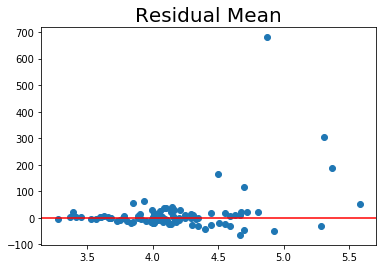

In [96]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)
#plt.savefig('./plots/residual.png')

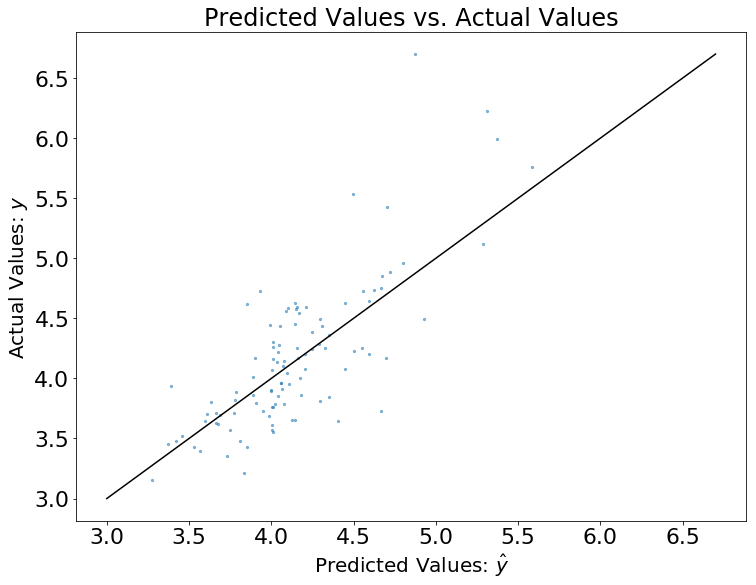

In [97]:

plt.figure(figsize=(12,9))
plt.rc('font', size=22)
# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_pred, y_test, s=5, alpha = 0.5)

# Plot a line.
plt.plot([3, np.max(y_test)],
         [3, np.max(y_test)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

In [98]:
pickle.dump(best_bag, open('../flask_app_complete/model.p', 'wb'))

In [99]:
test_model = pickle.load(open('../flask_app_complete/model.p','rb'))

In [100]:
test_pred=test_model.predict(X_cluster)

In [101]:
original_pred = best_bag.predict(X_cluster)

In [102]:
test_pred== original_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [103]:
X_cluster.columns.nunique()

64

In [104]:
#best_bag.feature_importance_

In [105]:
def affluency_predictor(to_predict):
    
    # format the variable
    session_int = int(to_predict.strip())
    
    df = pd.read_csv("../Data/X_cluster.csv")
    
    df = df[['zip_code', 'count', 'review_count', 'price*review_count', 'price_1', 'price_2',
      'price_3', 'price_4', 'rating_0.0', 'rating_1.0', 'rating_1.5',
      'rating_2.0', 'rating_2.5', 'rating_3.0', 'rating_3.5', 'rating_4.0',
      'rating_4.5', 'rating_5', 'cluster_0', 'cluster_1', 'cluster_2',
      'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7',
      'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12',
      'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17',
      'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22',
      'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27',
      'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31', 'cluster_32',
      'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36', 'cluster_37',
      'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41', 'cluster_42',
      'cluster_43', 'cluster_44', 'cluster_45']]
   
    # create array from dataframe row
    predict_array = df[df['zip_code'] == session_int]
    
    print(predict_array)
    
    # load trained model
    loaded_model = pickle.load(open("../flask_app_complete/model.p", "rb"))
    
    # predict//this is where error occurs
    result = loaded_model.predict(predict_array)
    
    print(result)
    print('------------')
    
    map_df = pd.read_csv('../data/data_zipcode.csv')
    la_coord = (34.0522, -118.2437)
    maps = folium.Map(location=la_coord, zoom_start=11)
    
    for each in map_df.iterrows():
        if int(each[1]['zip_code']) == session_int:
            popup_text = folium.Html(f""" 
                <strong>Zip Code: {each[1]["zip_code"].astype(int)}</strong> 
                </br>Avg. IRS Income (Thousands): {each[1]["ave_agi"].round(3)}
                </br>Predicted Income Thousands: {result[0].round(3)}
                </br>Avg. $ of Businesses: {each[1]["price"].round(3)}
                </br> Number of Businesses: {int(each[1]["count"])}""",
                script=True)
            
            popup = folium.Popup(popup_text, max_width=2650, show=True)

            coord = (each[1]['latitude'],each[1]['longitude'])
            
            maps = folium.Map(location=coord, zoom_start=13)
            
            
            folium.Marker(
                location = [each[1]['latitude'],each[1]['longitude']],
                popup=popup,
                clustered_marker = True).add_to(maps)
            
    

    return maps

In [106]:
#!pip install folium

In [107]:
import folium

In [108]:
affluency_predictor('90025')

    zip_code  count  review_count  price*review_count  price_1  price_2  \
23     90025    230    394.265217            654.8231       94      124   

    price_3  price_4  rating_0.0  rating_1.0  ...  cluster_36  cluster_37  \
23        8        4           0           0  ...           0           0   

    cluster_38  cluster_39  cluster_40  cluster_41  cluster_42  cluster_43  \
23           0           0           0           0           0           0   

    cluster_44  cluster_45  
23           0           0  

[1 rows x 64 columns]
[4.90273699]
------------
